# Clustering of drawn components in galaxy builder

### Problem:

*Given a set of ellipses and rotated rectangles (in zooniverse coordinates), how do we recover one aggregate shape for each task?*

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
from shapely.geometry import MultiPolygon
from shapely.affinity import scale, translate
from descartes import PolygonPatch
import lib.galaxy_utilities as gu
import get_average_shape as gas

In [3]:
font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)

Which subject should we work on? (parametrised to allow batch running at a later date)

In [4]:
subject_id = 20902040

Grab the galaxy data (and classification data) for this galaxy

In [5]:
print('Getting galaxy data')
gal, angle = gu.get_galaxy_and_angle(subject_id)
url = gu.getUrl(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
cls_for_s = gu.classifications.query(
    'subject_ids == {}'.format(subject_id)
)
annotations_for_subject = cls_for_s['annotations'].apply(
    json.loads
)
print('Found {} classifications for subject_id {}'.format(
    len(cls_for_s),
    subject_id,
))

Getting galaxy data
Found 32 classifications for subject_id 20902040


Convert these annnotations into "models" (galfit parameters)

In [6]:
models = annotations_for_subject.apply(
    gas.ash.remove_scaling
).apply(
    gas.pa.parse_annotation
)

In [7]:
print('Received:')
print('\t{} disks'.format(
    len(models.apply(lambda m: m.get('disk', False)).dropna())
))
print('\t{} bulges'.format(
    len(models.apply(lambda m: m.get('bulge', False)).dropna())
))
print('\t{} bars'.format(
    len(models.apply(lambda m: m.get('bar', False)).dropna())
))

Received:
	28 disks
	24 bulges
	17 bars


We can do some preliminary cleanup of the models (i.e. enforcing rectangular bars)

In [8]:
sanitized_models = models.apply(gas.sanitize_model)

And then grab the shapely geometries corresponding to these models

In [9]:
geoms = pd.DataFrame(
    sanitized_models.apply(gas.get_geoms).values.tolist(),
    columns=('disk', 'bulge', 'bar')
)

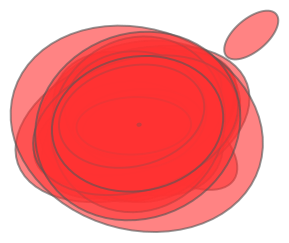

In [10]:
MultiPolygon(geoms['disk'].dropna().values.tolist())

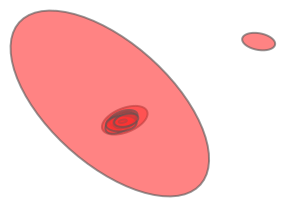

In [11]:
MultiPolygon(geoms['bulge'].dropna().values.tolist())

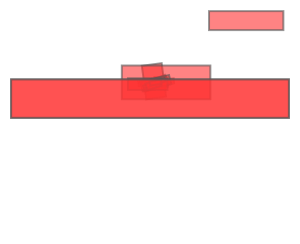

In [12]:
MultiPolygon(geoms['bar'].dropna().values.tolist())

Oh, and we want the spiral arms too! This uses the `gzbuilderspirals` package to cluster

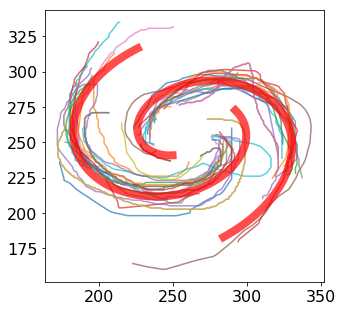

In [13]:
arms = gas.get_spiral_arms(subject_id, should_recreate=False)
plt.figure(figsize=(5, 5))
for arm in arms:
    for a in arm.arms:
        plt.plot(*a.T, alpha=0.7)
    plt.plot(*arm.reprojected_log_spiral.T, 'r', linewidth=8, alpha=0.7)

Now let's cluster the disks, bulges and bars. Chosen metric is based on the *Jaccard similarity score*:

$$S = \frac{\text{intersection area}}{\text{union area}}$$

Instead we use the *Jaccard distance*

$$D = 1 - \frac{\text{intersection area}}{\text{union area}}$$

In [14]:
labels = list(map(np.array, gas.cluster_components(geoms)))
cluster_labels = list(map(gas.ash.largest_cluster_label, labels))
cluster_masks = [a == b for a, b in zip(labels, cluster_labels)]

disk_cluster_geoms = geoms['disk'][cluster_masks[0]]
bulge_cluster_geoms = geoms['bulge'][cluster_masks[1]]
bar_cluster_geoms = geoms['bar'][cluster_masks[2]]

And calculate the shape which minimises the sum of Jaccard distances to each shape in a cluster

In [15]:
aggregate_disk = {
    **gas.aggregate_comp_mean(
        models[labels[0] == cluster_labels[0]].apply(
            lambda v: v.get('disk', None)
        ).dropna()
    ),
    **gas.aggregate_geom_jaccard(disk_cluster_geoms.values)
} if np.any(labels[0] == cluster_labels[0]) else None

# calculate an aggregate bulge
aggregate_bulge = {
    **gas.aggregate_comp_mean(
        models[labels[1] == cluster_labels[1]].apply(
            lambda v: v.get('bulge', None)
        ).dropna()
    ),
    **gas.aggregate_geom_jaccard(bulge_cluster_geoms.values)
} if np.any(labels[1] == cluster_labels[1]) else None

# calculate an aggregate bar
aggregate_bar = {
    **gas.aggregate_comp_mean(
        models[labels[2] == cluster_labels[2]].apply(
            lambda v: v.get('bar', None)
        ).dropna()
    ),
    **gas.aggregate_geom_jaccard(
        bar_cluster_geoms.values,
        constructor_func=gas.ash.box_from_param_list
    )
} if np.any(labels[2] == cluster_labels[2]) else None

In [16]:
print(aggregate_disk)
print(aggregate_bulge)
print(aggregate_bar)

{'i0': 0.24000000000000005, 'n': 1.0, 'c': 2.0, 'mu': [256.61093959956554, 255.31137838012515], 'roll': 2.8028735986180653, 'rEff': 93.19281026948728, 'axRatio': 0.7563982515800156}
{'i0': 0.603, 'n': 1.2069999999999999, 'c': 2.0, 'mu': [258.34985142650015, 253.97421235356543], 'roll': 2.871559943037639, 'rEff': 10.64624217932845, 'axRatio': 0.5500647545810514}
{'i0': 0.21, 'n': 0.51, 'c': 1.86, 'mu': [256.4799525835197, 252.9541540153222], 'roll': 2.896997225196092, 'rEff': 18.13486674106111, 'axRatio': 0.38622057028819695}


## Plotting for method paper

Define some useful goodies for plotting later (to transform from image coordinates to arcseconds from centre of galaxy)

In [17]:
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)

def transform_patch(p):
    return scale(
        translate(p, xoff=-pic_array.shape[0]/2, yoff=-pic_array.shape[1]/2),
        xfact=1/pix_size,
        yfact=1/pix_size,
        origin=(0, 0),
    )

def transform_arm(arm):
    return (arm - pic_array.shape[0]/2) / pix_size

imshow_kwargs = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        -pic_array.shape[0]/2 / pix_size,
        pic_array.shape[0]/2 / pix_size,
        -pic_array.shape[1]/2 / pix_size,
        pic_array.shape[1]/2 / pix_size
    ),
}

Let's see the drawn shapes overlaid on the galaxy:

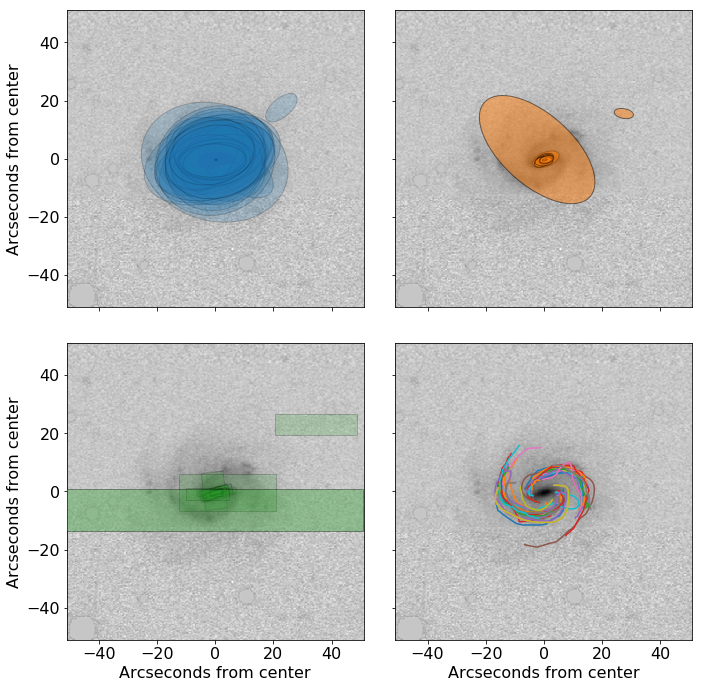

In [18]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    ncols=2, nrows=2,
    figsize=(10, 10),
    sharex=True, sharey=True
)
ax0.imshow(pic_array, **imshow_kwargs)
for comp in geoms['disk'].values:
    if comp is not None:
        ax0.add_patch(
            PolygonPatch(transform_patch(comp), fc='C0', ec='k',
                         alpha=0.2, zorder=3)
        )
ax1.imshow(pic_array, **imshow_kwargs)
for comp in geoms['bulge'].values:
    if comp is not None:
        ax1.add_patch(
            PolygonPatch(transform_patch(comp), fc='C1', ec='k',
                         alpha=0.5, zorder=3)
        )
ax2.imshow(pic_array, **imshow_kwargs)
for comp in geoms['bar'].values:
    if comp is not None:
        ax2.add_patch(
            PolygonPatch(transform_patch(comp), fc='C2', ec='k',
                         alpha=0.2, zorder=3)
        )
ax3.imshow(pic_array, **imshow_kwargs)
for arm in arms:
    for a in arm.arms:
        ax3.plot(*transform_arm(a).T)

for i, ax in enumerate((ax0, ax1, ax2, ax3)):
    ax.set_xlim(imshow_kwargs['extent'][:2])
    ax.set_ylim(imshow_kwargs['extent'][2:])
    if i % 2 == 0:
        ax.set_ylabel('Arcseconds from center')
    if i > 1:
        ax.set_xlabel('Arcseconds from center')
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig('method-paper-plots/drawn_shapes.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/drawn_shapes.png', bbox_inches='tight')

Our resulting clusters look like this: (empty sub-plot means no cluster)

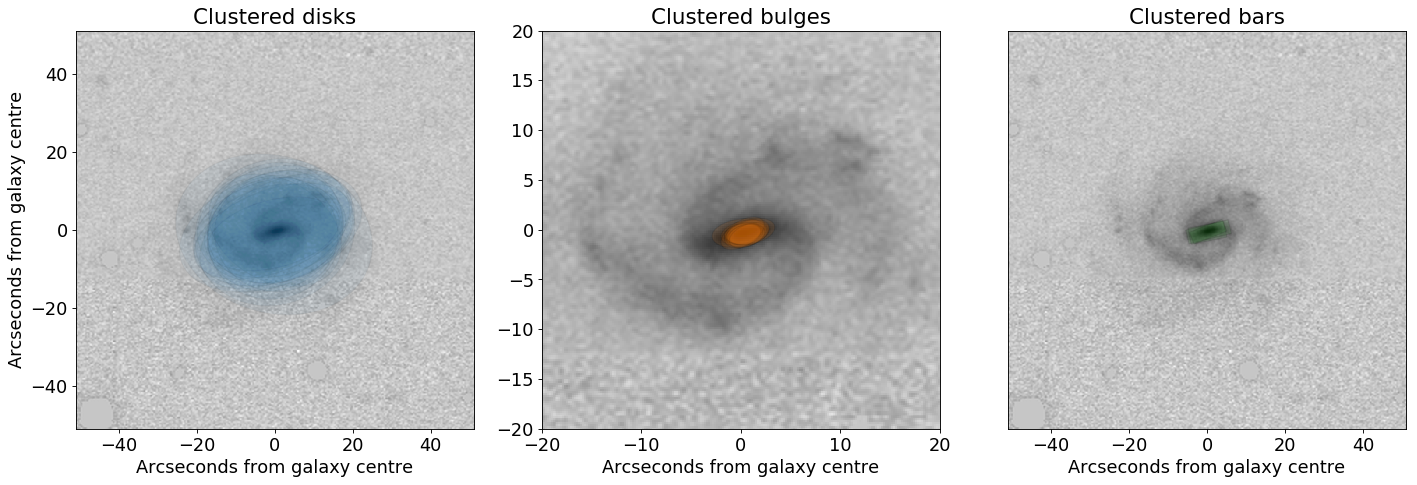

In [19]:
fig = plt.figure(1, figsize=(18, 6), dpi=80)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplot(131)
plt.imshow(pic_array, **imshow_kwargs)
for disk in disk_cluster_geoms:
    p = PolygonPatch(transform_patch(disk), fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.title('Clustered disks')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')

plt.subplot(132)
plt.imshow(pic_array, **imshow_kwargs)
for bulge in bulge_cluster_geoms:
    p = PolygonPatch(transform_patch(bulge), fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
# plt.yticks([])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.title('Clustered bulges')
plt.xlabel('Arcseconds from galaxy centre')

plt.subplot(133)
plt.imshow(pic_array, **imshow_kwargs)
for bar in bar_cluster_geoms:
    p = PolygonPatch(transform_patch(bar), fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.yticks([])
plt.title('Clustered bars')
plt.xlabel('Arcseconds from galaxy centre')

plt.tight_layout()
plt.savefig('method-paper-plots/clustered_shapes.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/clustered_shapes.png', bbox_inches='tight')

And the resulting aggregate shapes like this:

In [25]:
mean_disk_geom = gas.ash.make_ellipse(aggregate_disk)
mean_bulge_geom = gas.ash.make_ellipse(aggregate_bulge)
mean_bar_geom = gas.ash.make_box(aggregate_bar)

In [26]:
def make_patches(c=('C0', 'C1', 'C2')):
    mean_disk_patch = PolygonPatch(
        transform_patch(mean_disk_geom), fc=c[0], ec='k', alpha=0.4, zorder=3
    ) if mean_disk_geom is not None else None
    mean_bulge_patch = PolygonPatch(
        transform_patch(mean_bulge_geom), fc=c[1], ec='k', alpha=0.5, zorder=3
    ) if mean_bulge_geom is not None else None
    mean_bar_patch = PolygonPatch(
        transform_patch(mean_bar_geom), fc=c[2], ec='k', alpha=0.5, zorder=3
    ) if mean_bar_geom is not None else None

    return mean_disk_patch, mean_bulge_patch, mean_bar_patch

In [38]:
disk_crop = 30
bulge_crop = bar_crop = 15

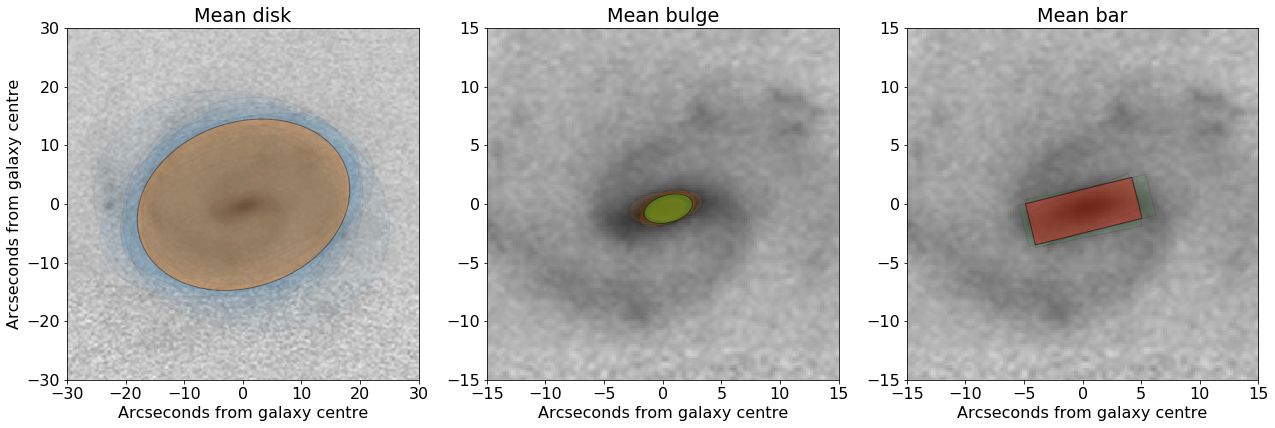

In [39]:
fig = plt.figure(1, figsize=(18, 6))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

mean_disk_patch, mean_bulge_patch, mean_bar_patch = make_patches(c=('C1', 'C2', 'C3'))

plt.subplot(131)
plt.imshow(pic_array, **imshow_kwargs)
for disk in disk_cluster_geoms:
    p = PolygonPatch(transform_patch(disk), fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(mean_disk_patch)
except AttributeError:
    pass
plt.title('Mean disk')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.xlim(-disk_crop, disk_crop)
plt.ylim(-disk_crop, disk_crop)


plt.subplot(132)
plt.imshow(pic_array, **imshow_kwargs)
for bulge in bulge_cluster_geoms:
    p = PolygonPatch(transform_patch(bulge), fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(mean_bulge_patch)
except AttributeError:
    pass
plt.title('Mean bulge')
plt.xlabel('Arcseconds from galaxy centre')
plt.xlim(-bulge_crop, bulge_crop)
plt.ylim(-bulge_crop, bulge_crop)

plt.subplot(133)
plt.imshow(pic_array, **imshow_kwargs)
for bar in bar_cluster_geoms:
    p = PolygonPatch(transform_patch(bar), fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(mean_bar_patch)
except AttributeError:
    pass
plt.title('Mean bar')
plt.xlabel('Arcseconds from galaxy centre')
plt.xlim(-bar_crop, bar_crop)
plt.ylim(-bar_crop, bar_crop)

plt.tight_layout()
plt.savefig('method-paper-plots/mean_shapes.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/mean_shapes.png', bbox_inches='tight')

And finally, let's see our resulting galaxy model

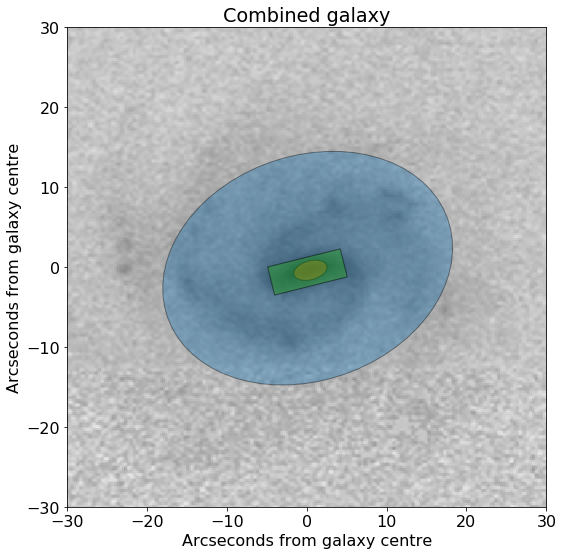

In [40]:
mean_disk_patch, mean_bulge_patch, mean_bar_patch = make_patches()
plt.figure(figsize=(8,8))
plt.title('Combined galaxy')
plt.imshow(pic_array, **imshow_kwargs)
try:
    plt.gca().add_patch(mean_disk_patch)
except AttributeError:
    pass
try:
    plt.gca().add_patch(mean_bulge_patch)
except AttributeError:
    pass
try:
    plt.gca().add_patch(mean_bar_patch)
except AttributeError:
    pass

plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.xlim(-disk_crop, disk_crop)
plt.ylim(-disk_crop, disk_crop)

plt.tight_layout()
plt.savefig('method-paper-plots/aggregate_model.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/aggregate_model.png', bbox_inches='tight')

And there we have it! A complex photometric model (sort of) fit to SDSS r-band data, performed using citizen science